In [1]:
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, ElectraTokenizer, ElectraModel
from transformers.modeling_outputs import TokenClassifierOutput
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import pandas as pd
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name_1 = "cardiffnlp/twitter-roberta-large-2022-154m"
model_name_2 = 'Twitter/twhin-bert-base'

# model_name_1 = "cardiffnlp/twitter-roberta-large-2022-154m"
# model_name_2 = 'ElKulako/cryptobert'

# model_name_1 = "cardiffnlp/twitter-roberta-large-2022-154m"
# model_name_2 = 'svalabs/twitter-xlm-roberta-crypto-spam'

# model_name_1 = "ElKulako/cryptobert"
# model_name_2 = 'svalabs/twitter-xlm-roberta-crypto-spam'



n1 = 0 # number of layers to freeze
n2 = 0 # number of layers to freeze
EPOCHS = 20

# batch size = mini_batch_size * accumulation_steps
mini_batch_size = 1
accumulation_steps = 16

max_tweet_len = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class TwoBodyModel(nn.Module):

    def __init__(self, model_1, model_2, num_labels):
        super(TwoBodyModel, self).__init__()
        self.num_labels = num_labels
        self.model_1 = AutoModel.from_pretrained(model_1)
        self.model_2 = AutoModel.from_pretrained(model_2)
        
        self.dropout_1 = nn.Dropout(0.2)
        self.dropout_2 = nn.Dropout(0.2)
        self.pre_classifier_1 = nn.Linear(self.model_1.config.hidden_size, self.model_1.config.hidden_size)
        self.pre_classifier_2 = nn.Linear(self.model_2.config.hidden_size, self.model_2.config.hidden_size)
        self.dropout_1_2 = nn.Dropout(0.1)
        self.dropout_2_2 = nn.Dropout(0.1)
        self.classifier_1 = nn.Linear(self.model_1.config.hidden_size+self.model_2.config.hidden_size, self.model_1.config.hidden_size+self.model_2.config.hidden_size)
        self.dropout_3 = nn.Dropout(0.2)
        self.classifier_2 = nn.Linear(self.model_1.config.hidden_size+self.model_2.config.hidden_size, num_labels)

    # def freeze_layers(self, model, num_layers):
    #     # Freeze the first 'num_layers' layers
    #     for i, layer in enumerate(model.encoder.layer):
    #         if i < num_layers:
    #             for param in layer.parameters():
    #                 param.requires_grad = False
    def freeze_all_layers(self):
        # Freeze the first 'num_layers' layers
        for i, layer in enumerate(self.model_1.encoder.layer):
            for param in layer.parameters():
                param.requires_grad = False
        for i, layer in enumerate(self.model_2.encoder.layer):
            for param in layer.parameters():
                param.requires_grad = False
                    
    def unfreeze_all_layers(self):
        # Freeze the first 'num_layers' layers
        for i, layer in enumerate(self.model_1.encoder.layer):
            for param in layer.parameters():
                param.requires_grad = True
        for i, layer in enumerate(self.model_2.encoder.layer):
            for param in layer.parameters():
                param.requires_grad = True

    def count_parameters(self):
            total_params = sum(p.numel() for p in self.parameters())
            total_trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            print(f'The model has {total_params:,} total parameters, and {total_trainable_params:,} trainable parameters')
    
    def forward(self, input_ids_1, input_ids_2, attention_mask_1, attention_mask_2, labels):

        output_1 = self.model_1(input_ids=input_ids_1, attention_mask=attention_mask_1)
        output_2 = self.model_2(input_ids=input_ids_2, attention_mask=attention_mask_2)

        pre_output_1 = self.dropout_1(F.gelu(output_1[0][:, 0, :]))
        pre_output_2 = self.dropout_2(F.gelu(output_2[0][:, 0, :]))

        pre_output_1 = self.pre_classifier_1(pre_output_1)
        pre_output_1 = self.dropout_1_2(F.gelu(pre_output_1))
        pre_output_2 = self.pre_classifier_2(pre_output_2)
        pre_output_2 = self.dropout_2_2(F.gelu(pre_output_2))
        output = self.classifier_1(torch.cat((pre_output_1, pre_output_2), 1))

        output = self.dropout_3(F.gelu(output))
        logits = self.classifier_2(output)

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels)

        return loss, logits

In [4]:
tokenizer_1 = AutoTokenizer.from_pretrained(model_name_1)
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)

In [5]:
train_df = pd.read_csv('/home/ubuntu/Profiling-Cryptocurrency-Influencers-with-FSL/data/finetune_train_val_test/train.csv')
validate_df = pd.read_csv('/home/ubuntu/Profiling-Cryptocurrency-Influencers-with-FSL/data/finetune_train_val_test/validate.csv')
train_df = train_df.groupby('twitter user id').agg({'texts': tokenizer_2.sep_token.join, 'class': 'first', 'count_mention': sum}).reset_index()
validate_df = validate_df.groupby('twitter user id').agg({'texts': ' '.join, 'class': 'first', 'count_mention': sum}).reset_index()

In [6]:
labels = train_df['class'].unique().tolist()
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels, label2id

(['nano', 'no influencer', 'macro', 'mega', 'micro'],
 {'nano': 0, 'no influencer': 1, 'macro': 2, 'mega': 3, 'micro': 4})

In [7]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, max_len, tweet_df):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.tweets_dataset = tweet_df
  
    def __len__(self):
        return len(self.tweets_dataset)
  
    def __getitem__(self, idx):
        tweet = self.tweets_dataset.iloc[idx]['texts']
        label = self.tweets_dataset.iloc[idx]['class']
        user_id = self.tweets_dataset.iloc[idx]['twitter user id']
        label = label2id[label]
        labels_matrix = np.zeros(5)
        labels_matrix[label] = 1
   
        encoding = self.tokenizer(
            text = tweet,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        return {
            'tweet': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(labels_matrix, dtype=torch.float),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'user_id': user_id
        }

In [8]:
train_dataset_1 = TweetDataset(tokenizer_1, max_tweet_len, train_df)
val_dataset_1 = TweetDataset(tokenizer_1, max_tweet_len, validate_df)
train_dataset_2 = TweetDataset(tokenizer_2, max_tweet_len, train_df)
val_dataset_2 = TweetDataset(tokenizer_2, max_tweet_len, validate_df)

In [9]:
train_data_loader_1 = DataLoader(train_dataset_1, batch_size=mini_batch_size, shuffle=True, num_workers=4)
val_data_loader_1 = DataLoader(val_dataset_1, batch_size=mini_batch_size, shuffle=True, num_workers=4)
train_data_loader_2 = DataLoader(train_dataset_2, batch_size=mini_batch_size, shuffle=True, num_workers=4)
val_data_loader_2 = DataLoader(val_dataset_2, batch_size=mini_batch_size, shuffle=True, num_workers=4)

In [10]:
model = TwoBodyModel(model_name_1, model_name_2, 5)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [11]:
param_optimizer = list(model.named_parameters())

In [12]:
def train_epoch(model, data_loader_1, data_loader_2, optimizer, device, scheduler, accumulation_steps): 
    model = model.train()
    losses = []
    total_acc = 0
    total_counter = 0
    acc = 0
    counter = 0
    strt = time.time()
    
    for i, d in enumerate(zip(data_loader_1, data_loader_2)):
        d_1, d_2 = d[0], d[1]

        input_ids_1 = d_1["input_ids"].reshape(d_1["input_ids"].shape[0], max_tweet_len).to(device)
        attention_mask_1 = d_1["attention_mask"].to(device)
        targets_1 = d_1["label"].to(device)

        input_ids_2 = d_2["input_ids"].reshape(d_2["input_ids"].shape[0], max_tweet_len).to(device)
        attention_mask_2 = d_2["attention_mask"].to(device)

        outputs = model(input_ids_1=input_ids_1, input_ids_2=input_ids_2, attention_mask_1=attention_mask_1,
                        attention_mask_2=attention_mask_2, labels=targets_1)

        loss = outputs[0]

        _, prediction = torch.max(outputs[1], dim=1)
        targets = torch.argmax(targets_1, dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = accuracy_score(targets, prediction)

        acc += accuracy
        total_acc += accuracy
        losses.append(loss.item())

        # Accumulate gradients
        loss = loss / accumulation_steps
        loss.backward()

        # Perform optimization step and zero gradients if it's the last accumulation step
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scheduler.step()

        counter += 1
        total_counter += 1

        if i % 1000 == 0 and i > 0:
            print('iteration ', i, '; acc: ', acc / counter)
            warnings.warn('iteration ' + str(i) + '; acc: ' + str(acc / counter) + '; time: ' + str(time.time() - strt) + ' s')
            acc = 0
            counter = 0
            print('time: ', time.time() - strt, ' s')
            strt = time.time()

    return total_acc / total_counter, np.mean(losses)

In [13]:
def eval_model(model, data_loader_1, data_loader_2, device):  #, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    preds = []
    targets_array = []
    logit_array = []
    
    with torch.no_grad():
        for i, d in enumerate(zip(data_loader_1, data_loader_2)):
            d_1, d_2 = d[0], d[1]
            input_ids_1 = d_1["input_ids"].reshape(d_1["input_ids"].shape[0], max_tweet_len).to(device)
            attention_mask_1 = d_1["attention_mask"].to(device)
            targets_1 = d_1["label"].to(device)

            input_ids_2 = d_2["input_ids"].reshape(d_2["input_ids"].shape[0], max_tweet_len).to(device)
            attention_mask_2 = d_2["attention_mask"].to(device)
            targets_2 = d_2["label"].to(device)
            
            outputs = model(input_ids_1=input_ids_1, input_ids_2=input_ids_2, attention_mask_1=attention_mask_1, attention_mask_2=attention_mask_2, labels=targets_1)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = torch.argmax(targets_1, dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = accuracy_score(targets, prediction)
            preds += list(prediction.flatten())
            targets_array += list(targets.flatten())

            acc += accuracy
            losses.append(loss.item())
            counter += 1


            logit_array += list(logits.cpu().detach().numpy())

    return acc / counter, np.mean(losses), preds, np.array(logit_array), targets_array

In [14]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.02},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.01}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader_1) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/home/ubuntu/venv/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The model has 639,050,501 total parameters, and 250,900,997 trainable parameters

Epoch 1/20
----------
Train loss 1.609300583847298 Train accuracy 0.18181818181818182
Val loss 1.6079650402069092 Val accuracy 0.2

Epoch 2/20
----------
Train loss 1.6082554040861523 Train accuracy 0.2396694214876033
Val loss 1.6110499143600463 Val accuracy 0.2

Epoch 3/20
----------
Train loss 1.6076200766996904 Train accuracy 0.19834710743801653
Val loss 1.6041122833887735 Val accuracy 0.2

Epoch 4/20
----------
Train loss 1.6076947401377781 Train accuracy 0.23140495867768596
Val loss 1.6062918583552042 Val accuracy 0.2

Epoch 5/20
----------
The model has 639,050,501 total parameters, and 639,050,501 trainable parameters
Train loss 1.6070984661086531 Train accuracy 0.256198347107438
Val loss 1.6079113483428955 Val accuracy 0.2

Epoch 6/20
----------
Train loss 1.5935002732868038 Train accuracy 0.23140495867768596
Val loss 1.592115863164266 Val accuracy 0.2

Epoch 7/20
----------
Train loss 1.583075642

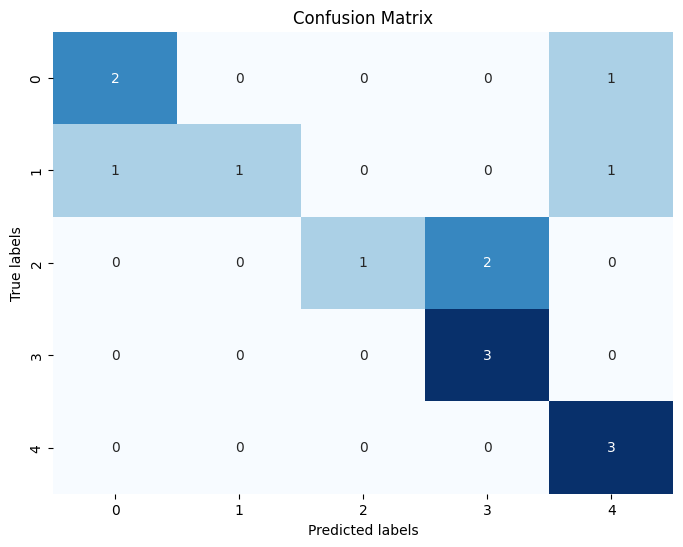

In [15]:
preds = []
real_preds = []
tt = None
pp = None
vacc = 0
# Freeze all encoder layers
model.freeze_all_layers()
model.count_parameters()
for epoch in range(EPOCHS):
    print()
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Unfreeze all encoders layers in epoch 4
    if (epoch+1 == 5):
        model.unfreeze_all_layers()
        model.count_parameters()

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader_1,
        train_data_loader_2,
        optimizer,
        device,
        scheduler,
        accumulation_steps
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss, predictions, val_logits, targets_arr = eval_model(
        model,
        val_data_loader_1,
        val_data_loader_2,
        device
    )
    if val_acc > vacc:
        tt = targets_arr
        pp = predictions
        vacc = val_acc

    print(f'Val loss {val_loss} Val accuracy {val_acc}')

    if epoch+1 > 12:
        # Save models after every epoch larger than 14 to avoid overfitting
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

cm = confusion_matrix(tt, pp)
print(classification_report(tt, pp))

# Create a heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set plot labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Display the plot
plt.show()